## AR

Slowly varying Gaussian noise $l(t)$ with timescale $\tau$ and marginal variance $\sigma^2$

$\mu_{t+1} = (1-\frac 1 \tau) l(t)$

$l(t\!+\!1) = \mathcal{N}\left(\mu_{t+1}, \frac {2 \sigma^2} \tau\right)$

We use this noise to perturb the confirmed cases, scaling them by the subsequent noise:

$c^\prime_t = c_t \times \exp(1 + l(t))$

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)
from pathlib import Path

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import (
    RandomWalkMobilityModel,
    MandateMobilityModel
)
import epimodel.viz.mandate_wearing as mw

from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.prior_posterior as pp

import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
import json

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set_style("white")


import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Set Theano Environmental Variables for Parallelisation


In [2]:
# argparser = argparse.ArgumentParser()
# argparser.add_argument('--model', dest='model', type=str, help='Model type')
# argparser.add_argument('--filter', dest='filtered', type=str, help='How to remove regions')
# argparser.add_argument('--masks', dest='masks', type=str, help='Which mask feature')
# argparser.add_argument('--w_par', dest='w_par', type=str, help='Which wearing parameterisation')
# argparser.add_argument('--mob', dest='mob', type=str, help='Which wearing parameterisation')
# args, _ = argparser.parse_known_args()

MODEL = "cases" #args.model
FILTERED = "nofilter" #args.filtered
MASKS = "wearing" #args.masks
W_PAR = "exp" # None

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

TUNING = 500
DRAWS = 300
CHAINS = 4

if MASKS == "mandate":
    n_mandates = 2
    


In [3]:
# prep data object

path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

../data/modelling_set/master_data_mob_include_us_True_m_w.csv


# Scale confirmed cases to represent changing ascertainment

In [4]:
# sigma^2 = marginal variance
# std = resulting noise variance
def noise(last_noise, timescale=7, variance=0.1):
    mean = (1 - (1/timescale)) * last_noise
    variance = (2 * variance) / timescale
    std = np.sqrt(variance)
    
    return np.random.normal(mean, std)


Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")
Rs = masks_object.df.reset_index().country.unique()
print("#Rs:", len(Rs))

def generate_noise(lt=0, scale=14, variance=0.1):
    noises = []
    for t in range(1, len(Ds)+1):
        if t % scale == 0 :
            lt = noise(lt)
        
        noises.append(lt)
    
    return np.array(noises)


def ascertainment_rate(lt):
    scaling = np.exp(lt + 1)
    return 1/scaling


def scale_cases(df, noises) :
    for r in Rs:
        rdf = df[df.country == r]
        
        for i, lt in enumerate(noises):
            scaling = np.exp(1 + lt)

            t = Ds[i].strftime("%Y-%m-%d")
            cases = rdf.loc[rdf['Date'] == t, 'ConfirmedCases']  
            rdf.loc[rdf['Date'] == t, 'ConfirmedCases'] = cases * scaling
        
        df[df.country == r] = rdf
    
    return df

#Rs: 145


In [5]:
# What range of ascertainment is this?
daily_noises = generate_noise(lt=0, scale=7, variance=0.1)
ars = ascertainment_rate(daily_noises)
min(ars), max(ars)

(0.33983521139118916, 0.7229346997471685)

In [42]:

l = []

for i in range(100):
    daily_noises = generate_noise(lt=0, scale=7, variance=0.1)
    ars = ascertainment_rate(daily_noises)
    l.append(ars)


l = np.array(l)
lo = np.percentile(l, 2.5, axis=0)
med = np.percentile(l, 50, axis=0)
hi = np.percentile(l, 97.5, axis=0)
lo

array([0.36787944, 0.36787944, 0.36787944, 0.36787944, 0.36787944,
       0.36787944, 0.26104781, 0.26104781, 0.26104781, 0.26104781,
       0.26104781, 0.26104781, 0.26104781, 0.27218679, 0.27218679,
       0.27218679, 0.27218679, 0.27218679, 0.27218679, 0.27218679,
       0.24349837, 0.24349837, 0.24349837, 0.24349837, 0.24349837,
       0.24349837, 0.24349837, 0.21791847, 0.21791847, 0.21791847,
       0.21791847, 0.21791847, 0.21791847, 0.21791847, 0.23209614,
       0.23209614, 0.23209614, 0.23209614, 0.23209614, 0.23209614,
       0.23209614, 0.23473327, 0.23473327, 0.23473327, 0.23473327,
       0.23473327, 0.23473327, 0.23473327, 0.21969776, 0.21969776,
       0.21969776, 0.21969776, 0.21969776, 0.21969776, 0.21969776,
       0.21939766, 0.21939766, 0.21939766, 0.21939766, 0.21939766,
       0.21939766, 0.21939766, 0.20437459, 0.20437459, 0.20437459,
       0.20437459, 0.20437459, 0.20437459, 0.20437459, 0.2115573 ,
       0.2115573 , 0.2115573 , 0.2115573 , 0.2115573 , 0.21155

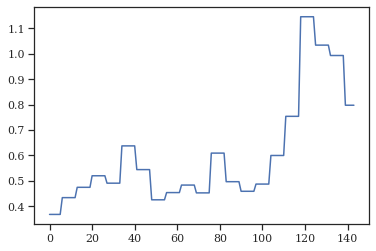

In [43]:
plt.plot(ars)

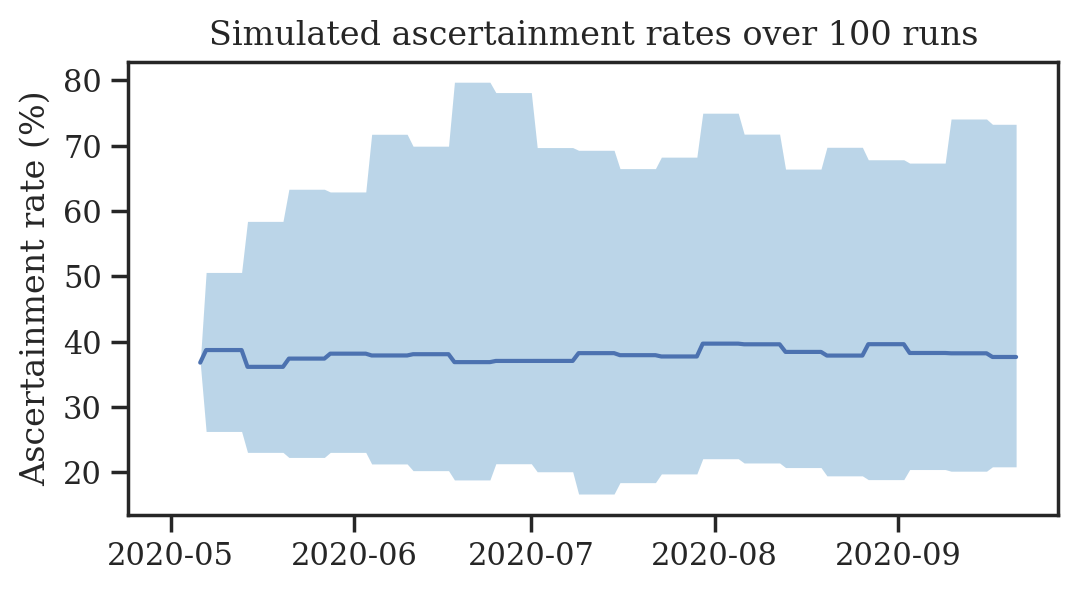

In [38]:
plt.figure(figsize=(4 * 1.5, 3), dpi=200)
plt.plot(Ds[5:], med[5:] * 100)
plt.fill_between(Ds, lo*100, hi*100, alpha=0.3, color="tab:blue", linewidth=0)
plt.ylabel("Ascertainment rate (%)")
plt.title("Simulated ascertainment rates over 100 runs")
plt.savefig(f"../outputs/ascertainment_ci.pdf", bbox_inches="tight")

In [6]:
copy = masks_object.df.copy().reset_index()
masks_object.df = scale_cases(copy, daily_noises) \
                    .set_index(["country", "Date"])

/home/gavin/.cache/pypoetry/virtualenvs/epimodel-TzvqHcGI-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
if MASKS == "mandate":
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True, n_mandates=n_mandates)
if MASKS == "wearing":
    print(MASKS)
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True)#, country_leavout_inds=inds)

masks_object.make_preprocessed_object()
data = masks_object.data

wearing
['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [8]:
print("How many regions?:", len(data.Rs))
print("How many NPIs?:", len(data.CMs))
print("How many days?:", len(data.Ds))

#len(data.Rs)* (len(data.Ds) - 30)
data.CMs

How many regions?: 98
How many NPIs?: 11
How many days?: 144


['C1_School closing',
 'C1_School closing_full',
 'C2_Workplace closing',
 'C2_Workplace closing_full',
 'C4_Restrictions on gatherings_3plus',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C4_Restrictions on gatherings_2plus',
 'C4_Restrictions on gatherings_full',
 'avg_mobility_no_parks_no_residential',
 'percent_mc']

In [9]:
# model specification
ep = EpidemiologicalParameters()
bd = ep.get_model_build_dict()


def set_init_infections(data, d):
    n_masked_days = 10
    first_day_new = data.NewCases[:, n_masked_days]
    first_day_new = first_day_new[first_day_new.mask == False]
    median_init_size = np.median(first_day_new)

    if median_init_size == 0:
        median_init_size = 50

    d["log_init_mean"] = np.log(median_init_size)
    d["log_init_sd"] = np.log(median_init_size)  # TODO: wide


set_init_infections(data, bd)

bd['wearing_parameterisation'] = W_PAR


if MODEL == "cases":
    del bd["deaths_delay_mean_mean"]
    del bd["deaths_delay_mean_sd"]
    del bd["deaths_delay_disp_mean"]
    del bd["deaths_delay_disp_sd"]

    
if MASKS == "mandate":
    bd['n_mandates'] = 1
    #bd['mask_mean'] = 0.2 / bd['n_mandates']
    bd['mask_sigma'] = 0.2
    
print(bd)
print(W_PAR)

{'gi_mean_mean': 5.06, 'gi_mean_sd': 0.3265, 'gi_sd_mean': 2.11, 'gi_sd_sd': 0.5, 'cases_delay_mean_mean': 10.92830227448381, 'cases_delay_mean_sd': 0.9387435298564465, 'cases_delay_disp_mean': 5.406593726647138, 'cases_delay_disp_sd': 0.2689502951493133, 'log_init_mean': 6.48197183311469, 'log_init_sd': 6.48197183311469, 'wearing_parameterisation': 'exp'}
exp


/home/gavin/.cache/pypoetry/virtualenvs/epimodel-TzvqHcGI-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [10]:
if MASKS == "wearing":
    with RandomWalkMobilityModel(data) as model:
        model.build_model(**bd)
        
elif MASKS == "mandate":
    with MandateMobilityModel(data) as model:
        model.build_model(**bd)
    

MASS = 'adapt_diag' 

with model:
    model.trace = pm.sample(
        DRAWS,
        tune=TUNING,
        cores=CHAINS,
        chains=CHAINS,
        max_treedepth=12,
        target_accept=0.9,
        init=MASS,
    )

10220
Argument: cases_delay_mean_sd not being used
Argument: cases_delay_disp_sd not being used
exp


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


KeyboardInterrupt: 

In [ ]:
trace = model.trace

In [ ]:
def main_result_posteriors(wred, ax):
    sns.kdeplot(wred, shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction\n(entire population masked)", fontsize=17)
    #ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    ax.set_ylabel("Posterior density", fontsize=17)
    ax.tick_params(axis='both', which='both', labelsize=18)
    
ax = plt.gca()
main_result_posteriors((1 - trace.WearingReduction.reshape(1200,)) * 100, ax)

In [ ]:
exp_pkl = "wearing_exp_cases_countries_92_05-31-02:56.pkl" # 1000 + 700 


def load_pickle(p) :
    path = 'pickles/' + p
    with open(path, 'rb') as buff:
        trace = pickle.load(buff)

    colfile = path[:-4] + "_cols"
    
    cf = Path(colfile)
    if cf.is_file():
        with open(colfile, "r") as f:
            npi_cols = f.read().split(", ")
    else :
        print("cols missing")
        npi_cols = []
    
    return trace, npi_cols


exp_trace, npi_cols = load_pickle(exp_pkl)

# SA plot

In [ ]:
from epimodel.plotting.intervention_plots import combine_npi_samples
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

def setup_plot(y_ticks = True, xlabel=True, x_lims=(-25, 100)):
    plt.figure(figsize=(4.5, 3), dpi=400)

    ax = plt.gca()
    x_min, x_max = x_lims
    xrange = np.array([x_min, x_max])
    plt.fill_between(xrange, 0.13, 0.87, color="silver", alpha=0.25, linewidth=0)

    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]

    plt.axvline(0, linestyle="--", color="black", linewidth=0.5)
    plt.yticks([])

    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    plt.xlim([x_min, x_max])
    plt.ylim([0, 1])

    plt.xlabel("Reduction in R", fontsize=9)


def add_trace_to_plot(samples, y_off, col, label, alpha, width, npi_comb_dict, cm_names, size=9):
    comb_effects = samples
    comb_effects = 100*(1-comb_effects)
    npi_order = list(npi_comb_dict.keys())
    
    nF = len(npi_order)

    y_vals = -np.array([npi_order.index(name) for name in ["Mask-wearing"]])
    plt.plot([1], [1], color=col, linewidth=1, alpha=alpha, label=label)

    li, lq, m, uq, ui = np.percentile(comb_effects, [2.5, 25, 50, 75, 97.5], axis=0)
    plt.scatter(m, y_vals+y_off, marker="o", color=col, s=size, alpha=alpha, facecolor='white', zorder=3, linewidth=width/2)

    plt.plot([li[0], ui[0]], [y_vals[0]+y_off, y_vals[0]+y_off], color=col, alpha=alpha*0.25, linewidth=width, zorder=2)
    plt.plot([lq[0], uq[0]], [y_vals[0]+y_off, y_vals[0]+y_off], color=col, alpha=alpha*0.75, linewidth=width, zorder=2)

cols = sns.color_palette('colorblind')
default_label = "All regions"

In [ ]:
#sigma01_scale14_trace = trace
sigma01_scale7_trace = trace
#sigma02_scale14_trace = trace



In [ ]:
title = "Wearing posterior under changing ascertainment"
grouped_dict = {
     'Mask-wearing' : {
        'npis': ['percent_mc'],
        'type': 'include',
        'color': cols[0],
        'main': True,
     }
}

setup_plot()


changingAscertainmentSamples = np.array(sigma02_scale14_trace.WearingReduction)
add_trace_to_plot(np.array(changingAscertainmentSamples), 
                  0.8, #0.5, 
                  cols[2], 
                  "$\sigma^2 = 0.2, τ = 14$", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

changingAscertainmentSamples = np.array(sigma01_scale7_trace.WearingReduction)
add_trace_to_plot(np.array(changingAscertainmentSamples), 
                  0.6, #0.5, 
                  cols[1], 
                  "$\sigma^2 = 0.1, τ = 7$", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

changingAscertainmentSamples = np.array(sigma01_scale14_trace.WearingReduction)
add_trace_to_plot(np.array(changingAscertainmentSamples), 
                  0.4, 
                  cols[0], 
                  "$\sigma^2 = 0.1, τ = 14$", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

samples = np.array(exp_trace.WearingReduction)
add_trace_to_plot(np.array(samples), 
                  0.2, 
                  (0,0,0), 
                  "Confirmed cases", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

plt.legend(shadow=True, fancybox=True, bbox_to_anchor=(0.99, 0.02), fontsize=7, loc="lower right") 
plt.title(title, fontsize=10)



#plt.show()

#plt.xticks()
plt.savefig(f"../outputs/sa_ascertainment_scaling.pdf", bbox_inches="tight")